# LocImpBranchPro: inference of R_t with negative binomial noise

The first part of the notebook includes a forward simulation of the local incidence numbers for an example branching process model with both local and imported cases and with negative binomial noise. The reproduction number profile is assumed to be a step function with only one jump. The incidence results are displayed as a barplot.

The second part of the notebook focuses on the computation of the posterior of the reproduction number for the inference using the data from the previous section, using two methods:
- using the posterior class implementation.

The mean and 95% interval quantiles are plotted together to illustrate a sensible trajectory of the R profile in time for both methods of inference.

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objects as go
import pandas as pd

num_timepoints = 30 # number of days for incidence data

# Build the imported cases
ic_mean = 70
imported_times = np.arange(1,(num_timepoints+1))
imported_cases = scipy.stats.poisson.rvs(ic_mean, size=num_timepoints)

## Parameterize example branching process model with local and imported cases

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

In [3]:
# Construct LocImpNegBinBranchProModel object
epsilon = 1
phi = 0.005

initial_r = 3
serial_interval = disc_w
m = branchpro.LocImpNegBinBranchProModel(initial_r, serial_interval, epsilon, phi)

new_rs = [1.5, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

m.set_imported_cases(imported_times, imported_cases)
locally_infected_cases = m.simulate(parameters, times)

print(locally_infected_cases)

[100.   0.  45.  65.  98. 123. 174. 213. 303. 299. 396. 513. 518. 664.
 747. 799. 312. 364. 371. 295. 219. 262. 206. 171. 176. 140. 126. 116.
 115. 107.]


## Plot local incidence numbers and imported cases

In [4]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=locally_infected_cases,
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=times,
        y=imported_cases,
        name='Imported Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## Inference plot using class method results

## Compute the posterior distribution using sampling class method

In [5]:
# Same inference, but using the LocImpPoissonBranchProPosterior
epsilon = 1
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

phi_mean = 0.5
phi_var = 10**(-0)
phi_rate = phi_var / phi_mean
phi_shape = phi_mean / phi_rate

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': imported_cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[1.5] + L2*[0.5]
})

inference_new = branchpro.LocImpNegBinBranchProLogPosterior(
    inc_data=inc_data,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon,
    daily_serial_interval=serial_interval,
    tau=tau,
    phi=phi,
    alpha=a,
    beta=b,
    phi_shape=phi_shape,
    phi_rate=1/phi_rate,
    infer_phi=True)


Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     60     0.5      3       0.03125  8       0.25     2        0:00.3
1     63                      0.25     1                         0:00.3
2     84                      0.0625   4                         0:00.4
3     129    0.581    6       0.5      2       0.5      16       0:00.6
20    582    0.744    7       0.758    10      0.757    6        0:02.6
40    1044   0.76     7       0.772401 8       0.76     8        0:04.6
60    1458   0.76     6       0.747    7       0.764    6        0:06.3
80    1866   0.766    7       0.756    7       0.761381 6        0:08.0
100   2038   0.657    6       0.753    6       0.657    6        0:08.7
Halting: Maximum number of iterations (100) reached.
Done!
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  --

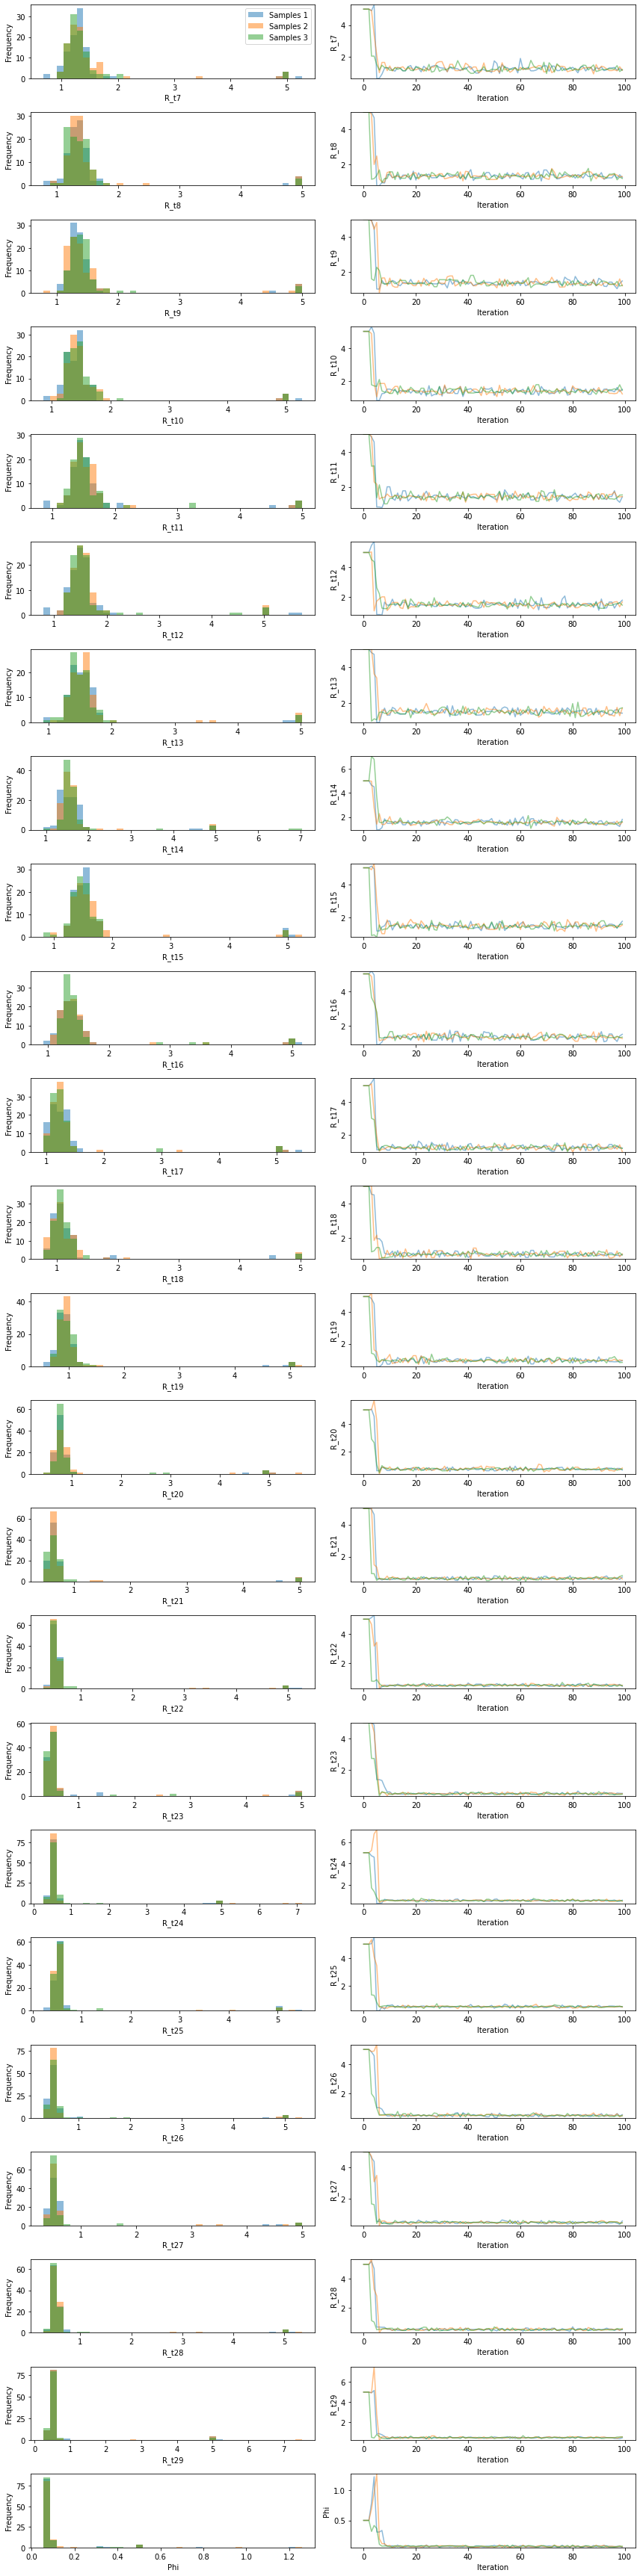

In [6]:
samples = inference_new.run_inference(num_iter=100)

import pints.plot
from matplotlib import pyplot as plt

# Plot histograms of the parameters inferred for South West
param_names = []

if inference_new._infer_phi is True:
    for _ in range(inference_new.lprior.n_parameters()-1):
        param_names.append('R_t{}'.format(_ + R_t_start))
    param_names.append('Phi')

    pints.plot.trace(samples, parameter_names=param_names)
    plt.show()

    # Eliminate burn-in iterations (1/2 of the chain lengths)
    samples_old = samples.copy()
    samples = samples[:, 50:, :-1]

else:
    for _ in range(inference_new.lprior.n_parameters()):
        param_names.append('R_t{}'.format(_ + R_t_start))

    pints.plot.trace(samples, parameter_names=param_names)
    plt.show()

    # Eliminate burn-in iterations (1/2 of the chain lengths)
    samples_old = samples.copy()
    samples = samples[:, 50:, :]


# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 50))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [7]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



In [8]:
dLl = []
old_r_profile = ground_truth['R_t'].to_list()

total_time = inference_new.ll.cases_times.max() - inference_new.ll.cases_times.min() + 1
time_init_inf_r = inference_new.ll._tau + 1

if inference_new._infer_phi is True:
    old_r_profile.append(phi)

    for _, time in enumerate(range(time_init_inf_r+1, total_time+2)):
        new_r_profile = old_r_profile.copy()
        new_r_profile[_] = old_r_profile[_] + 10**(-5)
        dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

else:
    for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
        new_r_profile = old_r_profile.copy()
        new_r_profile[_] = old_r_profile[_] + 10**(-5)
        dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

print(dLl)
print(inference_new.ll._compute_derivative_log_likelihood(old_r_profile))

[-47.85014316439628, -40.222430834546685, -42.1558041125536, -30.674022855237123, -10.832655243575573, -6.169790867716073, -1.6604608390480278, 1.277448609471321, -14.374259626492856, 2329.7433566767722, 2009.9778368603436, 1628.0548705253748, 1281.953026773408, 827.4712192360311, 420.0667317491024, 8.184288162738085, 15.782192349433897, 37.54441859200597, 6.820604903623461, -10.374520206823945, 9.02063911780715, -21.57370327040553, -23.822014918550845, 264070.34017320257]
[-47.849314109288684, -40.22130030466917, -42.15451107908768, -30.67253234516943, -10.830920942300281, -6.16790173822119, -1.6584216449507494, 1.2796135051530655, -14.372075270077403, 2329.79283156414, 2010.0238083218965, 1628.0961750698689, 1281.9896723243091, 827.5010733230165, 420.0901408686377, 8.20077676936944, 15.798201148907538, 37.55994296162453, 6.834828198533614, -10.361280620757498, 9.033508570795675, -21.561984230557755, -23.810974532786076, 264403.68562599673]


In [9]:
output_optimisation = inference_new.run_optimisation()[0]

shape = []
rate = []
mean = []

i=0

if inference_new._infer_phi is True:
    theta_hat, phi_hat = output_optimisation[:-1], output_optimisation[-1]

    for _, t in enumerate(range(R_t_start,num_timepoints)):
        shape.append( a + math.fsum(locally_infected_cases[(t-tau):(t+1)]) )
        sum_var = np.zeros_like(locally_infected_cases[(t-tau):(t+1)])
        for k_inx, k in enumerate(range(t-tau,t+1)):
            vec1 = locally_infected_cases[(k-1)::-1] # I_loc_(k-1), ... , I_loc_0
            vec2 = imported_cases[(k-1)::-1] # I_imp_(k-1), ... , I_imp_0
            vec3 = serial_interval[:k] # w_1, ... , w_k
            sum_var_loc = math.fsum( np.multiply(vec1,vec3) )
            sum_var_imp = math.fsum( np.multiply(vec2,vec3) )
            sum_var[k_inx] = sum_var_loc + epsilon * sum_var_imp # vector of sum^k_{s=0} w_s I_{k-s}

        rate.append(np.sum(
            np.multiply(np.multiply(locally_infected_cases[(t-tau):(t+1)] + 1/phi_hat, np.square(sum_var)), np.reciprocal(np.square(theta_hat[_] * sum_var + 1/phi_hat)))))
        i += 1

else:
    theta_hat = output_optimisation

    for _, t in enumerate(range(R_t_start,num_timepoints)):
        shape.append( a + math.fsum(locally_infected_cases[(t-tau):(t+1)]) )
        sum_var = np.zeros_like(locally_infected_cases[(t-tau):(t+1)])
        for k_inx, k in enumerate(range(t-tau,t+1)):
            vec1 = locally_infected_cases[(k-1)::-1] # I_loc_(k-1), ... , I_loc_0
            vec2 = imported_cases[(k-1)::-1] # I_imp_(k-1), ... , I_imp_0
            vec3 = serial_interval[:k] # w_1, ... , w_k
            sum_var_loc = math.fsum( np.multiply(vec1,vec3) )
            sum_var_imp = math.fsum( np.multiply(vec2,vec3) )
            sum_var[k_inx] = sum_var_loc + epsilon * sum_var_imp # vector of sum^k_{s=0} w_s I_{k-s}

        rate.append(np.sum(
            np.multiply(np.multiply(locally_infected_cases[(t-tau):(t+1)] + 1/phi, np.square(sum_var)), np.reciprocal(np.square(theta_hat[_] * sum_var + 1/phi)))))
        i += 1

# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

S_vector = np.reciprocal(np.multiply(np.array(shape)-1, np.reciprocal(np.square(theta_hat))) - np.array(rate))
S = np.diag(S_vector)

# q_theta = scipy.stats.multivariate_normal(theta_hat, S)
q_theta1 = scipy.stats.norm(theta_hat, np.sqrt(S_vector))
interval2 = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': q_theta1.mean(),
    'Lower bound CI': q_theta1.interval(0.95)[0],
    'Upper bound CI': q_theta1.interval(0.95)[1],
    'Central Probability': (L1+L2) * [0.95]
})

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 13
Iter. Eval.  Best      Current   Time m:s
0     13      256356.9  256356.9   0:00.1
1     26      256364.2  256364.2   0:00.1
2     39      256382.1  256382.1   0:00.1
3     52      256383.3  256383.3   0:00.1
20    273     256442.8  256439.2   0:00.6
40    533     256516    256515.7   0:01.1
60    793     256552.8  256551.9   0:01.6
80    1053    256559    256559     0:02.1
100   1313    256560.2  256560.2   0:02.6
120   1573    256560.3  256560.3   0:03.1
140   1833    256560.4  256560.4   0:03.6
160   2093    256560.4  256560.4   0:04.1
180   2353    256560.4  256560.4   0:04.6
187   2431    256560.4  256560.4   0:04.7
Halting: No significant change for 100 iterations.
[1.26240994 1.32152002 1.34146888 1.40121828 1.46550199 1.49004223
 1.50403494 1.51198981 1.47660667 1.34736339 1.20560914 1.04540236
 0.91622848 0.76240645 0.63253222 0.5075007  0.50901893 

In [10]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval2)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

